In [255]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [234]:
main_path = 'D:/Resumes and Internships/Tests/Decathlon'

In [235]:
def get_path(path, extension='csv'):
    try:
        path = os.path.join(main_path, path + '.' + extension)
    except:
        path = os.path.join('.', path + '.' + extension)
    
    return path

In [236]:
df_train = pd.read_csv(get_path('data/train'))
df_test  = pd.read_csv(get_path('data/test'))
df_feat  = pd.read_csv(get_path('data/bu_feat'))

In [237]:
df_train.head(10)

,day_id,but_num_business_unit,dpt_num_department,turnover
0,2017-09-30,64,127,580.308443
1,2017-09-30,119,127,1512.995918
2,2017-09-30,4,88,668.593556
3,2017-09-30,425,127,0.000000
4,2017-09-30,513,73,0.000000
5,2017-09-30,211,88,271.276864
6,2017-09-30,10,117,21.436326
7,2017-09-30,177,88,193.990051
8,2017-09-30,39,73,265.385406
9,2017-09-30,214,88,718.790912


In [238]:
df_test.head(10)

,day_id,but_num_business_unit,dpt_num_department
0,2017-11-25,95,73
1,2017-11-25,4,117
2,2017-11-25,113,127
3,2017-11-25,93,117
4,2017-11-25,66,127
5,2017-11-25,225,88
6,2017-11-25,37,117
7,2017-11-25,720,73
8,2017-11-25,1015,127
9,2017-11-25,505,88


In [239]:
df_feat.head(10)

,but_num_business_unit,but_postcode,but_latitude,but_longitude,but_region_idr_region,zod_idr_zone_dgr
0,1609,80100,50.096306,1.867220,69,4
1,1995,95700,48.991087,2.520903,3,6
2,1800,73210,45.552933,6.644736,51,4
3,238,47550,44.175370,0.638869,134,10
4,201,13546,43.508418,5.406423,71,10
5,242,72610,48.404324,0.087680,72,6
6,541,73100,45.718899,5.923290,51,4
7,95,80000,49.869382,2.280452,69,4
8,74,49071,47.467695,-0.619092,72,6
9,119,74100,46.195037,6.254448,51,4


In [240]:
df_train.describe()

,but_num_business_unit,dpt_num_department,turnover
count,277719.000000,277719.000000,277719.000000
mean,294.199464,101.288832,561.818472
std,291.664511,21.667318,2113.229765
min,1.000000,73.000000,-69.791165
25%,81.000000,88.000000,11.785140
50%,204.000000,88.000000,232.724186
75%,427.000000,127.000000,676.655825
max,1887.000000,127.000000,1000000.000000


In [241]:
df_test.describe()

,but_num_business_unit,dpt_num_department
count,10136.000000,10136.000000
mean,414.886346,101.207577
std,445.932616,21.679104
min,1.000000,73.000000
25%,95.000000,88.000000
50%,237.000000,88.000000
75%,549.000000,117.000000
max,1887.000000,127.000000


In [242]:
df_feat.describe()

,but_num_business_unit,but_postcode,but_latitude,but_longitude,but_region_idr_region,zod_idr_zone_dgr
count,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000
mean,435.162577,51203.460123,47.002270,2.637551,63.199387,12.202454
std,474.138722,26716.870578,2.333283,2.786303,47.901374,18.605263
min,1.000000,1100.000000,41.954300,-4.436446,2.000000,1.000000
25%,97.250000,31000.000000,44.959619,0.707571,31.000000,4.000000
50%,242.500000,56050.000000,47.373887,2.598707,64.000000,6.000000
75%,553.750000,74575.000000,48.885216,4.904543,74.000000,10.000000
max,1995.000000,98000.000000,51.050275,8.796100,178.000000,72.000000


In [243]:
print("Number of rows with NaN values in train table   : ", len(df_train[df_train.isnull().any(axis=1)]))
print("Number of rows with NaN values in test table    : ", len(df_test[df_test.isnull().any(axis=1)]))
print("Number of rows with NaN values in features table: ", len(df_feat[df_feat.isnull().any(axis=1)]))

Number of rows with NaN values in train table   :  0
Number of rows with NaN values in test table    :  0
Number of rows with NaN values in features table:  0


In [244]:
df_train = df_train.merge(df_feat, on='but_num_business_unit', how='left').sort_values(by=['day_id'])
df_test  = df_test.merge(df_feat, on='but_num_business_unit', how='left').sort_values(by=['day_id'])

In [245]:
limit_n_rows = 20000
df_train = df_train.iloc[:limit_n_rows,:]

In [246]:
def process_date_col(df):
    """
    Create date related columns from the date
    """
    df = df.copy()
    df.loc[:, "date"] = pd.to_datetime(df["day_id"])
    df.loc[:, "year"] = df["date"].dt.year
    df.loc[:, "month"] = df["date"].dt.month
    df.loc[:, "day"] = df['date'].dt.day
    df.loc[:, "dow"] = df["date"].dt.weekday
    df.loc[:, "dmy"] =  df['year'].astype(str) + df['month'].astype(str).str.zfill(2)+ df['day'].astype(str).str.zfill(2)
    df.loc[:, "weekend"] = df["dow"].isin([5,6]).astype(int)
    return df

In [247]:
df_train = process_date_col(df_train)
df_test  = process_date_col(df_test)

In [248]:
train_cols = ['year', 'day', 'month', 'dmy', 'dow', 'weekend', 'but_num_business_unit', 'dpt_num_department', 'but_postcode', 'but_latitude',
              'but_longitude', 'but_region_idr_region', 'zod_idr_zone_dgr']

target = ['turnover']

In [249]:
df_train[train_cols]

,year,day,month,dmy,dow,weekend,but_num_business_unit,dpt_num_department,but_postcode,but_latitude,but_longitude,but_region_idr_region,zod_idr_zone_dgr
277718,2012,29,12,20121229,5,1,54,73,13127,43.436266,5.256322,71,10
277040,2012,29,12,20121229,5,1,255,73,73200,45.656025,6.369133,51,4
277039,2012,29,12,20121229,5,1,812,73,56300,48.054208,-2.946356,7,6
277038,2012,29,12,20121229,5,1,24,73,59494,50.380010,3.475574,65,4
277037,2012,29,12,20121229,5,1,201,127,13546,43.508418,5.406423,71,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
257301,2013,11,5,20130511,5,1,178,127,50470,49.596891,-1.603431,30,6
257300,2013,11,5,20130511,5,1,118,117,59650,50.644545,3.142438,65,4
257313,2013,11,5,20130511,5,1,127,88,82000,43.984650,1.333475,134,10
257299,2013,11,5,20130511,5,1,251,117,33270,44.814453,-0.525461,31,10


In [250]:
train_data[target]

,turnover
277718,53.337413
277040,0.000000
277039,43.619478
277038,5.237134
277037,825.383999
...,...
247032,0.000000
247031,1.094777
247030,484.716053
247029,1779.513864


C:\Users\Youssef\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:80: UserWarning: Attempting to set identical left == right == 5.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
C:\Users\Youssef\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:80: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
C:\Users\Youssef\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:81: UserWarning: Attempting to set identical bottom == top == 5.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
C:\Users\Youssef\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:71: UserWarning: Attempting to set identical left == right == 5.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])
C:\Users\Youssef\anaconda3\l

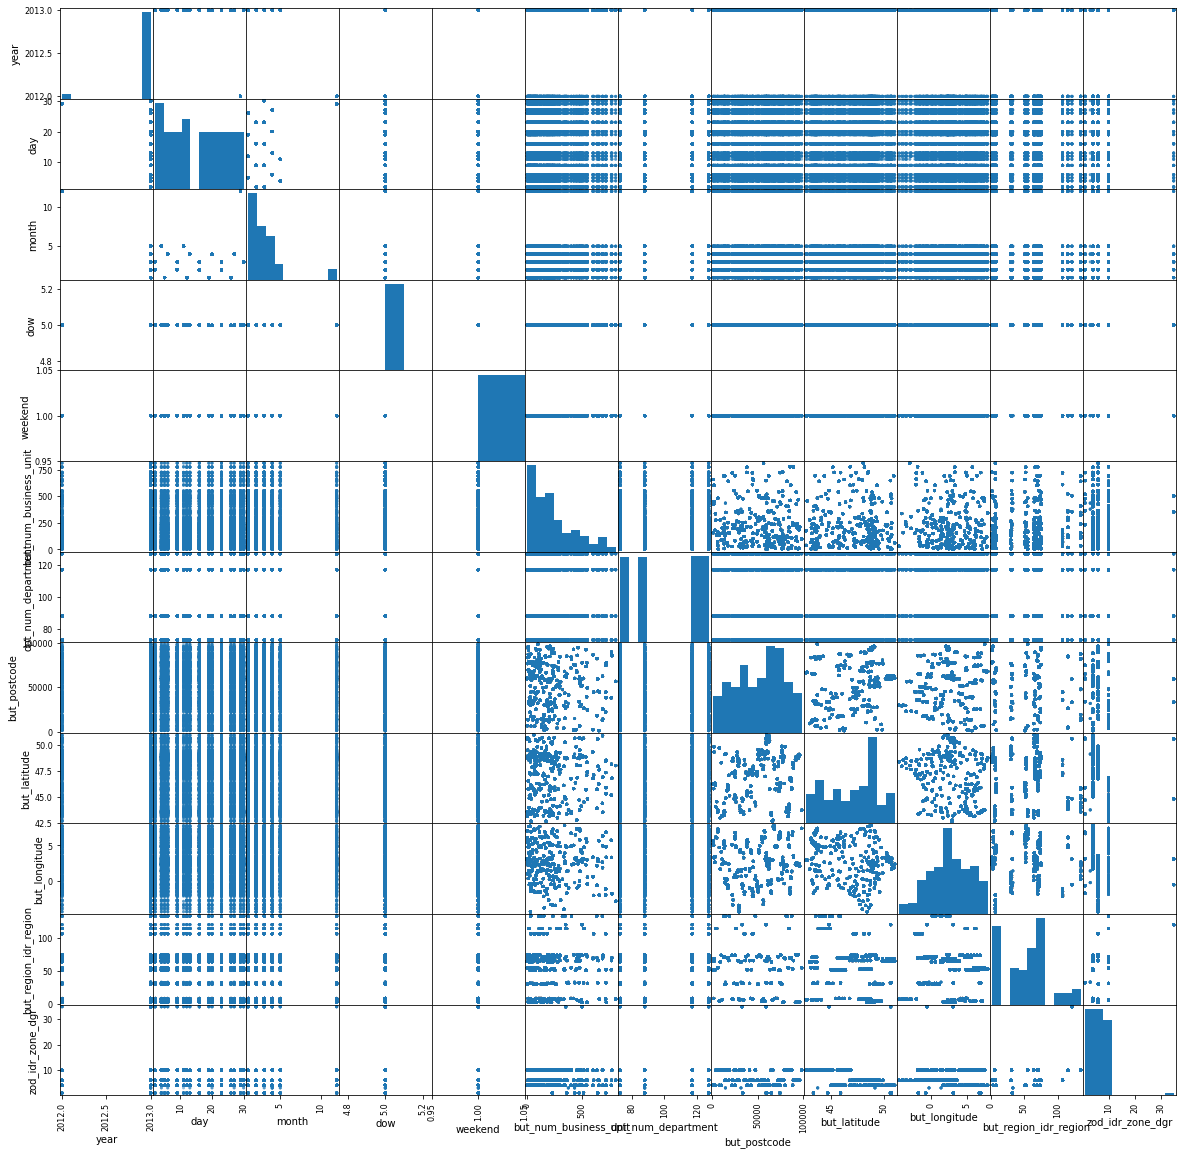

In [251]:
_ = pd.plotting.scatter_matrix(df_train[train_cols], figsize=(20,20))

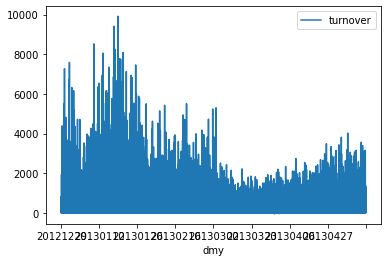

In [252]:
df_train.plot(x='dmy', y='turnover')

            day_id  but_num_business_unit  dpt_num_department     turnover  \
271677  2013-02-02                    149                  73     2.510519   
271676  2013-02-02                      8                 117  1692.181214   
271675  2013-02-02                    252                  88   706.557374   
271674  2013-02-02                     84                  73    23.978637   
271673  2013-02-02                     78                 127  1017.483452   
271672  2013-02-02                    539                  88   544.473218   
271671  2013-02-02                    132                 127  2549.136809   

        but_postcode  but_latitude  but_longitude  but_region_idr_region  \
271677         77124     48.956571       2.863658                      2   
271676         94000     48.774977       2.438007                     75   
271675         88000     48.187603       6.473633                     53   
271674         72650     48.040159       0.174054                     7

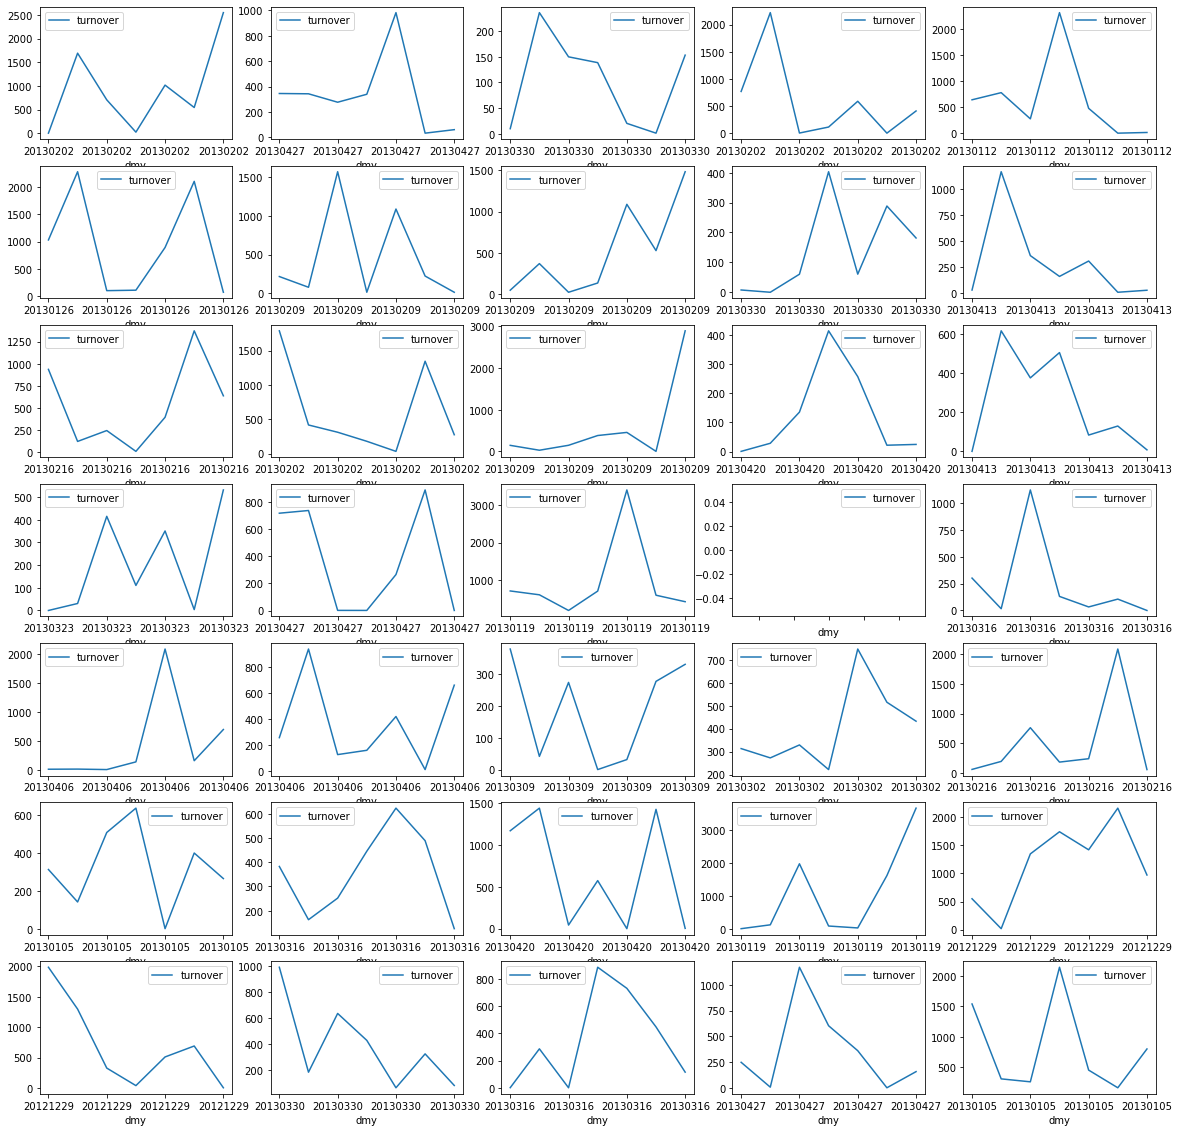

In [263]:
random_plot = False
nrow, ncol = 7, 5
fig, axes = plt.subplots(nrow, ncol, figsize=(20,20))

# plot counter
counter = 0
for row in range(nrow):
    for col in range(ncol):
        offset = np.random.randint(0,len(df_train))
        if not random_plot:
            df_tmp = df_train.iloc[offset+counter*7:offset+(counter+1)*7, :]
        else:
            tmp_offset = np.random.randint(0,6)
            df_tmp = df_train.iloc[tmp_offset:tmp_offset+7, 'turnover']

        print(df_tmp)
        df_tmp.plot(ax=axes[row,col], x='dmy', y='turnover')
        counter += 1